In [66]:
import time
import numpy as np
from scipy.optimize import fmin

In [9]:
from matplotlib import pyplot as plt


def graficar_error(eje_x, eje_y):
    """
    Funcion para realizar la grafica de error, iteraciones vs || ∇f(xk) ||
    :param eje_x: lista con todos los valores que deben graficarse en el eje x
    :param eje_y: lista con todos los valores que deben graficarse en el eje y
    """
    # Lista iteraciones en el eje x
    # Lista fxk en el eje y
    plt.plot(eje_x, eje_y)  # Se asignan los valores a los ejes de coordenadas
    plt.xlabel('Iteracion')  # Se le coloca un nombre al eje x
    plt.ylabel('|| ∇f(xk) ||')  # Se le coloca un nombre al eje y
    plt.title("Grafica de Iteracion vs || ∇f(xk) ||")
    plt.show()  # Se despliega el grafico


In [10]:
from sympy import MatrixSymbol, Symbol, lambdify, diff
from numpy import matrix, ones, zeros, linalg
from scipy import optimize


def mmb_secuencial(n, tol):
    """
    Metodo de Mejora Maxima por Bloque
    :param n: Cantidad de filas y columnas de la matriz tridiagonal
    :param tol: Tolerancia al fallo que debe tener el resultado
    :return: Matriz x calculada con el metodo
    """
    if n <= 1:
        return "El parametro n debe ser mayor a 1"

    # Se crea la matriz tridiagonal y la matriz de resultados
    matriz_a = crear_matriz_a(n)
    matriz_b = crear_matriz_b(n)

    # Se crea el vector inicial
    vec_x = matrix(ones((n, 1), dtype='object'))

    # Se crean las variables simbolicas
    simbolos = [MatrixSymbol('A', n, n),
                MatrixSymbol('b', n, 1),
                MatrixSymbol('x', n, 1)]

    simb_a = simbolos[0]  # Variable simbolica de la matriz A
    simb_b = simbolos[1]  # Variable simbolica de la matriz b
    simb_x = simbolos[2]  # Variable simbolica de la matriz x

    # Se crea la funcion que debe ser evaluada
    f = 1/2 * simb_x.T * simb_a * simb_x - simb_b.T * simb_x
    funcion = lambdify(simbolos, f)  # f(A, b, x)

    z = Symbol('z')

    vec_x_simbolico = []
    # Se crean todas las variables simbolicas del vector
    for i in range(0, n):
        vec_x_simbolico.append([Symbol('x' + str(i))])

    # Se construye una np.matrix a partir del vector obtenido
    vec_x_simbolico = matrix(vec_x_simbolico)

    gradiente = calcular_gradiente(funcion, matriz_a, matriz_b, vec_x_simbolico)

    # Se crean los vectores para las iteraciones
    vec_x1_aux = matrix(zeros((n, 1), dtype='object'))
    vec_error = matrix(zeros((n, 1), dtype='object'))

    # Se crean las listas para graficar el error
    lista_iter = []
    lista_error = []

    itr = 1  # Contador de iteraciones

    while 1:
        # Se calcula el vector k+1 utilizando la regla de Jacobi
        for j in range(0, n):
            copia_vec_x = vec_x.copy()
            copia_vec_x[j] = z

            # Se evalua la funcion con el vec_x con la variable simbolica
            ecuacion = funcion(matriz_a, matriz_b, copia_vec_x)

            # Se crea la funcion a minimizar
            fun_minimizar = lambdify(z, ecuacion.item(0))

            # Se minimiza la funcion
            resultado = optimize.minimize_scalar(fun_minimizar).x

            # Se actualiza el vector de la iteracion actual
            vec_x1_aux[j] = resultado

            # Se calcula el valor para el vector de error
            copia_vec_x[j] = resultado
            vec_error[j] = funcion(matriz_a, matriz_b, copia_vec_x)

        # Se obtiene la posicion del menor elemento en el vector de error
        i = vec_error.argmin()

        # Se actualiza el valor en la posicion minima
        vec_x[i] = vec_x1_aux[i]

        # Se calcula el vector para verificar la condicion de parada
        vec_parada = evaluar_gradiente(gradiente, vec_x_simbolico, vec_x)

        norma_2 = linalg.norm(vec_parada, 2)

        lista_iter.append(itr)
        lista_error.append(norma_2)

        # Se verifica la condicion de parada
        if norma_2 < tol:
            break

        itr += 1

    graficar_error(lista_iter, lista_error)

    return vec_x


def calcular_gradiente(f, matriz_a, matriz_b, vec_x_simbolico):
    """
    Calculo del gradiente de una funcion matematica
    :param f: Funcion lambdify a la que calcularle el gradiente
    :param matriz_a: Matriz A
    :param matriz_b: Matriz b
    :param vec_x_simbolico: Vector x con todas las variables simbolicas
    :return: Gradiente calculado
    """
    gradiente = []
    m = matriz_b.shape[0]

    # Se evalua la funcion con el vector simbolico
    funcion = f(matriz_a, matriz_b, vec_x_simbolico).item(0)

    # Se calcula el gradiente de la funcion obtenida
    for j in range(0, m):
        df = diff(funcion, vec_x_simbolico[j]).tolist()[0][0]

        gradiente.append(df)

    return gradiente


def evaluar_gradiente(gradiente, variables, vector):
    """
    Funcion para evaluar el gradradiente con un vector ingresado
    :param gradiente: gradiente que se debe evaluar
    :param variables: lista con las variables simbolicas de la ecuacion
    :param vector: vector que se debe evaluar en el gradiente
    :return: resultado de evaluar el vector en el gradiente
    """
    n = len(variables)
    resultado = []

    # Se recorre cada una de las derivadas parciales en el gradiente
    for i in range(0, n):
        # Se obtiene la derivada parcial
        funcion = gradiente[i]

        # Se sustituyen cada una de las variables por el valor en el vector
        for x in range(0, n):
            funcion = funcion.subs(variables.item(x), vector.item(x))

        resultado += [[funcion.doit()]]

    return matrix(resultado, dtype='float')


def crear_matriz_a(n):
    """
    Funcion encargada de crear la matriz tridiagonal A
    :param n: Numero de filas y columnas de la matriz
    :return:
    """
    # Se crea una matriz de n x n
    matriz_a = matrix(zeros((n, n), dtype='int'))

    # Caso especial primera fila
    matriz_a[0, 0] = 6
    matriz_a[0, 1] = 2

    # Se itera sobre las filas de la matriz para establecer los valores
    for i in range(1, n - 1):
        matriz_a[i, i] = 6
        matriz_a[i, i - 1] = 2
        matriz_a[i, i + 1] = 2

    # Caso especial ultima fila
    matriz_a[n - 1, n - 1] = 6
    matriz_a[n - 1, n - 2] = 2

    return matriz_a


def crear_matriz_b(n):
    """
    Funcion encargada de crear la matriz b de una columna
    :param n: Numero de filas
    :return: Matriz creada
    """
    # Se crea un vector columna de n x 1
    matriz_b = matrix(zeros((n, 1), dtype='int'))

    # Caso especial primera fila
    matriz_b[0, 0] = 12

    # Se itera sobre las filas de la matriz para establecer los valores
    for i in range(1, n - 1):
        matriz_b[i, 0] = 15

    # Caso especial ultima fila
    matriz_b[n - 1, 0] = 12

    return matriz_b




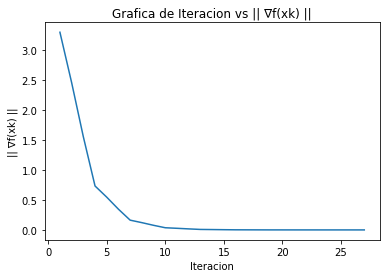

time: 0.34541988372802734
[[11.999999999999972]
 [15.000009229301348]
 [12.000000133259906]]
[[1.4999993439370392]
 [1.5000019681888688]
 [1.4999993661470281]]


In [414]:
n = 3
start = time.time()
r = mmb_secuencial(n, 10**-5)
end = time.time()
delta=end-start
print("time:",delta)
a = crear_matriz_a(n)
v = a * r
print(v)
print(r)

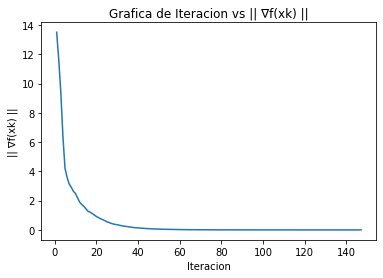

time: 13.972124338150024
[[11.999997862150192]
 [15.000001976973923]
 [15.000000266519898]
 [15.000005332702283]
 [15.00000041191733]
 [15.0000051674028]
 [14.99999973348011]
 [15.000002344714872]
 [14.999996622340504]
 [12.000003277468677]]
[[1.4999993907434834]
 [1.5000007588446458]
 [1.4999993212095406]
 [1.5000014107866815]
 [1.4999991127815568]
 [1.5000014568273141]
 [1.4999991004379]
 [1.5000011085990415]
 [1.4999987461224118]
 [1.5000009642039756]]


In [504]:


n = 10
start = time.time()
r = mmb_secuencial(n, 10**-5)
end = time.time()
delta=end-start
print("time:",delta)
a = crear_matriz_a(n)
v = a * r
print(v)
print(r)

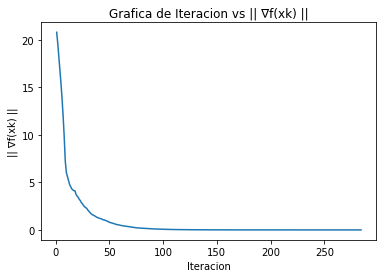

time: 108.00505304336548
[[11.999999733480015]
 [15.000003998690524]
 [14.999999733479996]
 [14.999999840662902]
 [14.99999986673997]
 [14.999996410267183]
 [15.00000168559708]
 [14.999999498224176]
 [15.000003989722307]
 [15.000000411917178]
 [15.000003903354669]
 [14.999998413382414]
 [15.000000266520063]
 [14.999997504080772]
 [14.999999866739948]
 [14.999998824178316]
 [15.000001692453942]
 [14.999997469148267]
 [15.0000030428085]
 [11.999997547249427]]


In [21]:

n = 20
start = time.time()
r = mmb_secuencial(n, 10**-5)
end = time.time()
delta=end-start
print("time:",delta)
a = crear_matriz_a(n)
v = a * r
print(v)

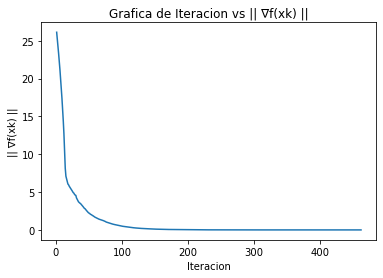

time: 495.7772753238678
[[12.000000501776494]
 [15.000001939274226]
 [14.999999352827851]
 [15.000003234775116]
 [14.999998308595817]
 [15.000001401682361]
 [14.999999352827745]
 [15.000001696143643]
 [15.000000411916702]
 [15.000000941632987]
 [14.99999683711788]
 [14.999999866739913]
 [14.999997246078687]
 [15.000000501775173]
 [14.999998337994974]
 [15.000002480082228]
 [14.999999352827885]
 [15.000002864454588]
 [14.999999498223959]
 [15.00000069918708]
 [14.999999223833305]
 [14.99999730844476]
 [15.000002615833006]
 [14.999998700568447]
 [15.00000000000001]
 [14.999997189307622]
 [15.000000133260055]
 [14.999998265618498]
 [15.000002328552025]
 [11.999997519078022]]


In [20]:
n = 30
start = time.time()
r = mmb_secuencial(n, 10**-5)
end = time.time()
delta=end-start
print("time:",delta)
a = crear_matriz_a(n)
v = a * r
print(v)

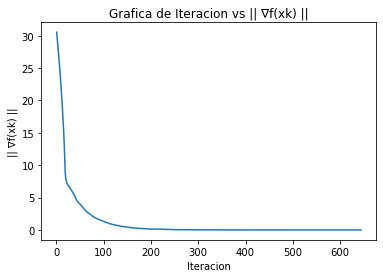

time: 1347.4337058067322
[[11.999999352827492]
 [15.000001987327689]
 [14.999999364846035]
 [15.00000050177555]
 [14.99999802316476]
 [15.000000501775327]
 [14.999997718817704]
 [15.000000501775173]
 [14.99999728122199]
 [15.000001471635304]
 [14.99999973348009]
 [15.00000242227048]
 [15.000000501776924]
 [15.00000071537755]
 [14.999997903867177]
 [15.000003023540469]
 [14.999998504245461]
 [14.999999733479878]
 [14.999997964194907]
 [15.000000133259938]
 [15.000001561303755]
 [14.9999987508579]
 [15.000002282406701]
 [14.999998901563252]
 [15.000000783208993]
 [15.000000411916698]
 [15.000001891297025]
 [14.999999866739998]
 [15.000002737204136]
 [15.000000501777171]
 [15.000002744518987]
 [14.999998857765098]
 [14.999999733479967]
 [14.999999492802054]
 [15.000001645002225]
 [14.999998059396056]
 [15.000000133260027]
 [14.9999991449507]
 [15.000002530005974]
 [12.000000501776645]]


In [22]:
n = 40
start = time.time()
r = mmb_secuencial(n, 10**-5)
end = time.time()
delta=end-start
print("time:",delta)
a = crear_matriz_a(n)
v = a * r
print(v)

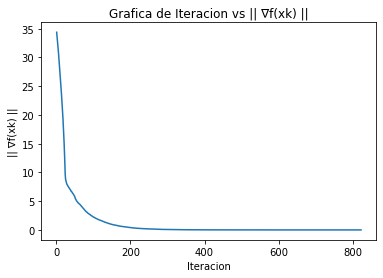

time: 2744.539119243622
[[11.999999866740012]
 [15.000001806759478]
 [14.999998744780132]
 [15.000000598994625]
 [14.999999498224007]
 [15.000002299882683]
 [14.99999973348002]
 [15.000002282733753]
 [14.999999352827698]
 [15.000001686781332]
 [15.000001027827741]
 [15.000002513410267]
 [14.999998482220025]
 [15.000001027822247]
 [14.99999799068389]
 [14.999999866739955]
 [14.999998768078632]
 [15.000000852636536]
 [15.000001768636169]
 [14.99999842715019]
 [14.999999866739923]
 [14.999998577500827]
 [15.000000579398394]
 [15.000000882430125]
 [15.00000195505967]
 [14.999998366255204]
 [14.999999498223477]
 [14.999998366255255]
 [15.000001230307516]
 [14.999998241739359]
 [14.999999498223485]
 [14.99999838713581]
 [15.000001800049239]
 [14.999998860073674]
 [15.000000882426768]
 [14.99999860207977]
 [15.000000882427118]
 [14.999999620883257]
 [15.00000185490865]
 [14.99999973348007]
 [15.000002899334014]
 [14.999999498224055]
 [15.000000898314477]
 [14.999997542244081]
 [15.00000050177

In [23]:
n = 50
start = time.time()
r = mmb_secuencial(n, 10**-5)
end = time.time()
delta=end-start
print("time:",delta)
a = crear_matriz_a(n)
v = a * r
print(v)

In [358]:
def create_A(n):
    up =np.diag(np.ones(n-1)*2,1)
    down =np.diag(np.ones(n-1)*2,-1)
    center=np.diag(np.ones(n)*6,0)
    return np.matrix(up+down+center, dtype='float')
create_A(10)

matrix([[6., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 6., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 6., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 6., 2., 0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 6., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 6., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 6., 2., 0., 0.],
        [0., 0., 0., 0., 0., 0., 2., 6., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 2., 6., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 2., 6.]])

In [359]:
def create_b(n):
    b = np.ones(n)*15
    b[-1]=12
    b[0]=12
    return np.matrix(b, dtype='float').T
create_b(10)

matrix([[12.],
        [15.],
        [15.],
        [15.],
        [15.],
        [15.],
        [15.],
        [15.],
        [15.],
        [12.]])

In [360]:
def create_x0(n):
    return np.matrix(np.ones(n), dtype='float').T
create_x0(10)

matrix([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [361]:
np.ones(5)*5

array([5., 5., 5., 5., 5.])

In [362]:
def fun(A,b,x):
    return ((1/2)*x.T*A*x-b.T*x).item()

In [478]:
n=10
A=create_A(n)
b=create_b(n)
x_0=create_x0(n)


fun(A,b,x_0)

-96.0

In [479]:
x_0

matrix([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [480]:
def grad_fun(X,A,b):
    x_size=len(X)
    grad = np.zeros(x_size)
    for i in range(0,x_size):
        grad[i]= (1/2) * ( A.T[i]*X+A[i]*X)-(b[i])
    return grad



In [481]:
grad_f = lambda x:  grad_fun(x,A,b)
# grad_fun(x_0,A,b)
grad_f(x_0)

array([-4., -5., -5., -5., -5., -5., -5., -5., -5., -4.])

In [482]:

def jacobi(f,X_0):
    x_size=len(X_0)
    results=np.zeros(x_size)
    for i in range(0,x_size):
        f_i = lambda x :f_n(f,x_0,i,x)
        results[i]=fmin(f_i,X_0[i],disp=False)
    return matrix(results).T

def f_n(f,X,n,x):
    X_local= np.copy(X)
    X_local[n]=x
    return f(X_local)
    

In [483]:
f = lambda x: fun(A,b,x)
jacobi(f, x_0)

matrix([[1.66669922],
        [1.83330078],
        [1.83330078],
        [1.83330078],
        [1.83330078],
        [1.83330078],
        [1.83330078],
        [1.83330078],
        [1.83330078],
        [1.66669922]])

In [513]:
def mmb(f, grad_f,x_0,tol=10**-1, disp=False):
    x_k=np.copy(x_0)
    x_size= len(x_k)
    cont=0
    norm_grad_prev=np.linalg.norm(grad_f(x_k))
    while(  norm_grad_prev >tol ):
        e=zeros(x_size)
        x_tem=zeros(x_size)
        for i in range(x_size):
            f_i = lambda x :f_n(f,x_k,i,x)
            x_min = fmin(f_i,x_k[i],disp=False)
            x_tem[i]=x_min
#               x_tem=jacobi(f, x_0)
            x_k_tem = np.copy(x_k)
            x_k_tem[i]=x_min
            e[i]=f(x_k_tem)
        i = e.argmin()
        x_k[i]=x_tem[i]
        norm_grad_current=np.linalg.norm(grad_f(x_k))
        if(disp):
#             print(cont,"error:",np.linalg.norm(grad_f(x_k)))
            print(cont,norm_grad_prev-norm_grad_current )
        norm_grad_prev=norm_grad_current
        cont+=1
    return x_k
          
          

In [515]:
n=10
A=create_A(n)
b=create_b(n)
x_0=create_x0(n)
f = lambda x: fun(A,b,x)
grad_f = lambda x:  grad_fun(x,A,b)
start = time.time()
result = mmb(f,grad_f,x_0,10**-4,disp=True)

end = time.time()
delta=end-start
print("-"*100)
print(result)
print("-"*100)
print("time:",delta)




0 1.7202067722273124
1 1.8780034901668614
2 2.2464985068978134
3 2.9922358886740987
4 2.1780408787101466
5 0.6194503553675399
6 0.46215928715110177
7 0.21414373575819523
8 0.2541975515618762
9 0.17969661072732457
10 0.2955165328876781
11 0.2833738074669325
12 0.17329883990035988
13 0.11455429871264067
14 0.1679764854872945
15 0.17207795486707145
16 0.06608645943079128
17 0.09158410692401131
18 0.09283922586811033
19 0.10700100394173595
20 0.07970875640349706
21 0.07345153963731677
22 0.06450737263823114
23 0.06608129626824188
24 0.07544329142404349
25 0.05367350572372598
26 0.05420512581381415
27 0.04419067566608281
28 0.03327561332881618
29 0.023473862313340588
30 0.03497469849018303
31 0.02801510190633555
32 0.030316404831094212
33 0.015168491732146766
34 0.021911200125430574
35 0.023207619020471693
36 0.020311302924249625
37 0.020116094402369472
38 0.014470272448199928
39 0.006955311197841402
40 0.012053857873655982
41 0.011118753384443777
42 0.013375147150234218
43 0.00856387829366

KeyboardInterrupt: 

matrix([[30.],
        [45.],
        [42.]])

matrix([[240.]])

In [464]:
a = np.array([8,2,3])
a

array([8, 2, 3])

In [465]:
np.linalg.norm(a)

8.774964387392123

In [466]:
a.argmin()


1

In [527]:
def mmb_rev(f, grad_f,x_0,tol=10**-1, disp=False):
    x_k=np.copy(x_0)
    x_size= len(x_k)
    cont=0
    norm_grad_prev=np.linalg.norm(grad_f(x_k))
    while(  norm_grad_prev >tol ):
        e=zeros(x_size)
        x_tem=zeros(x_size)
        for i in range(x_size):
            f_i = lambda x :f_n(f,x_k,i,x)
            x_min = fmin(f_i,x_k[i],disp=False,ftol=10**-15)
            x_tem[i]=x_min
#               x_tem=jacobi(f, x_0)
            x_k_tem = np.copy(x_k)
            x_k_tem[i]=x_min
            e[i]=f(x_k_tem)
        i = e.argmin()
        x_k[i]=x_tem[i]
        norm_grad_current=np.linalg.norm(grad_f(x_k))
        if(disp):
#             print(cont,"error:",np.linalg.norm(grad_f(x_k)))
            print(cont,norm_grad_prev-norm_grad_current )
        norm_grad_prev=norm_grad_current
        cont+=1
    return x_k
          

In [531]:
n=50
A=create_A(n)
b=create_b(n)
x_0=create_x0(n)
f = lambda x: fun(A,b,x)
grad_f = lambda x:  grad_fun(x,A,b)
start = time.time()
result = mmb_rev(f,grad_f,x_0,10**-5,disp=True)

end = time.time()
delta=end-start
print("-"*100)
print(result)
print("-"*100)
print("time:",delta)



0 0.7115520647899771
1 0.7265897199976621
2 0.7088875254072136
3 0.7244763043636766
4 0.8294842966115681
5 0.7612001611431864
6 0.7806005094490587
7 0.8015644356994187
8 0.9228800464574043
9 0.9541996387131313
10 0.8830915518172269
11 0.9137980988508083
12 1.0619022796595807
13 0.9910598632143426
14 1.0350740897848034
15 1.2169168948870812
16 1.1517210512421023
17 1.2225119364408314
18 1.3082227283114207
19 1.4149710920501128
20 1.3618116827883515
21 1.5024641220699984
22 1.6985143502754223
23 0.7259952019703224
24 0.7790317463150753
25 0.8457306655881656
26 0.27096518768831324
27 0.2795834502524688
28 0.15936533413002962
29 0.23308677368851782
30 0.23997606342921518
31 0.13825429110394793
32 0.10028416308301757
33 0.10161741609351527
34 0.10300530254180362
35 0.10445165884071539
36 0.14878174034618308
37 0.10818767130568752
38 0.10986718634290771
39 0.11162743693502986
40 0.06785782216603486
41 0.02277019689874127
42 0.2241976320356116
43 0.10303587197237274
44 0.17001911076374032
45 